# Exercises

## Part A: The structure of the Philosopher network

*Exercises*: Structure of the the philosopher network

Last time, we found the most connected philosophers (using degree centrality). Now let's dig in and try to understand more about the philosopher network using more advanced network features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below (in a directed graph use the weakly connected component).

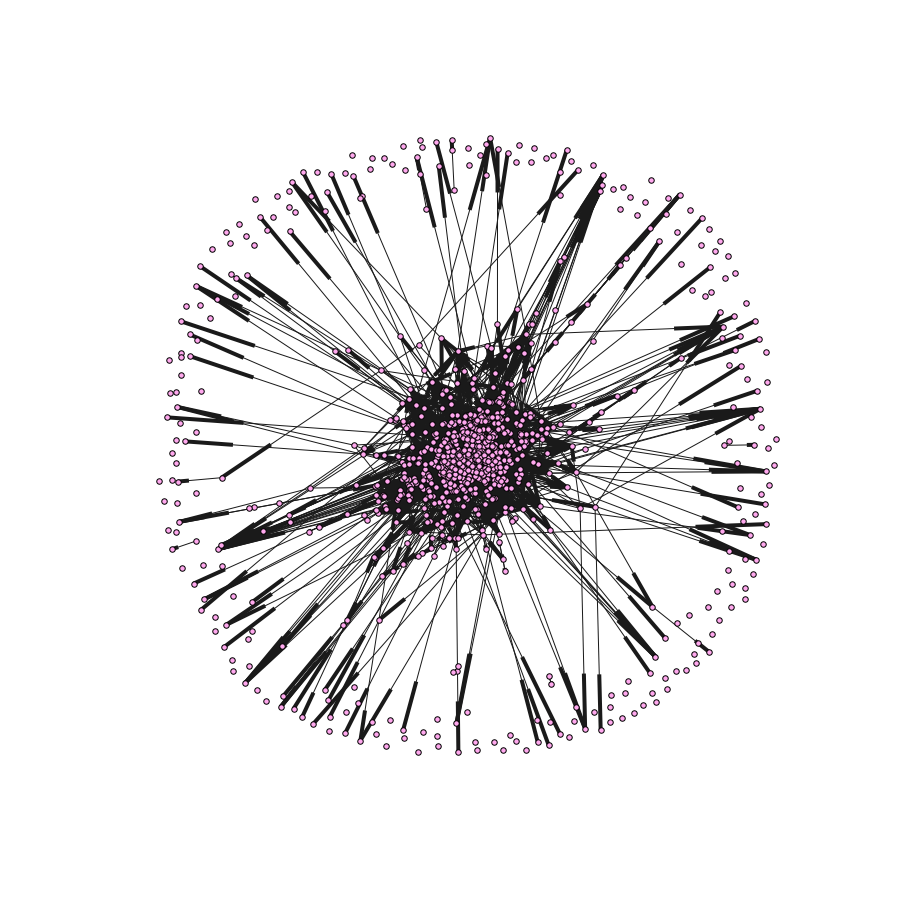

In [2]:
from os import listdir
from os.path import isfile, join
import networkx as nx
import matplotlib.pyplot as plt
import cPickle as pickle
import re
%matplotlib inline 

# First, recreate the graph from last week

def load_philosopher_from_file(file_name):
    with open(file_name, 'rb') as f:
        philosopher_json = pickle.load(f)
        return philosopher_json

def get_list_of_philosophers_files(directory):
    files = [join(directory, f) for f in listdir(directory) if isfile(join(directory, f))]
    return files

# Redefine the regex - we don't need to take into account this time the leading * as we did earlier on 
re_wiki_link = r'\[\[([^\[\]|]+)[^\[\]]*\]\]'

philosophers_dir = './philosophers'

# Create a standard graph
phi_network = nx.DiGraph()

# Get all the files with the philosophers information
philosopher_files = get_list_of_philosophers_files(philosophers_dir)

philosophers_unique = set()
philosophers = []

for philosopher_file in philosopher_files:
    philosopher_wikipage = load_philosopher_from_file(philosopher_file)
    
    philosopher_pages = philosopher_wikipage['query']['pages']
    philosopher_content = philosopher_pages[philosopher_pages.keys()[0]]
    
    # Add node in the network
    philosopher_name = philosopher_content['title']
    phi_network.add_node(philosopher_name)
    
    # Add philosopher to unique list
    philosophers_unique.add(philosopher_name)
    philosophers.append(philosopher_content)
    
for philosopher_content in philosophers:
    # Retrieve the content in the page
    content_in_page = philosopher_content['revisions'][0]['*']
    
    # Find all links in the page
    links_in_page = re.findall(re_wiki_link, content_in_page)
    
    # Find all links in the page that refer to philosophers in our list using set's intersection
    connections = list(philosophers_unique.intersection(set(links_in_page)))
    
    philosopher_name = philosopher_content['title']
    
    # Add the edges to the network 
    connections_to_add = [(philosopher_name, connection) for connection in connections]
    phi_network.add_edges_from(connections_to_add)

# Plot the network     
pos = nx.spring_layout(phi_network)
plt.figure(1,figsize=(12,12))
nx.draw(phi_network, node_size=30, node_color="#FFA8EE", node_shape='o', edge_color='.1', with_labels=False, width=1, pos=pos)
plt.show()

* **Not all of the measures we'll be considering below are defined for directed graphs, thus begin by creating an undirected version of the philosopher graph, that we can use whenever needed. Only use the undirected graph when explicitly stated in the exercise.**

In [3]:
# Make the philosophers network an undirected graph
undirected_phi_network = phi_network.to_undirected()

* **Find the 5 most central philosophers according to betweenness centrality. What role do you imagine philosophers with high wikipedia graph betweenness centrality play in the history of philosophy?**

In [4]:
# Compute the betweenness centrality
phi_between_centrality = nx.betweenness_centrality(undirected_phi_network)

# Sort the dictionary (thus the iteritems) by the value in descending order (thus the "-")
phi_between_centrality_sorted = sorted(phi_between_centrality.iteritems(), key=lambda (name, value): -value)

print "The 5 most central philosophers according to betweenness centrality :\n" 
print phi_between_centrality_sorted[:5]

The 5 most central philosophers according to betweenness centrality :

[(u'Aristotle', 0.08051969440565435), (u'Immanuel Kant', 0.07704721969305633), (u'Bertrand Russell', 0.0662171565693034), (u'Plato', 0.05112539640728451), (u'David Hume', 0.04352885999009065)]


* ** Find the 5 most central philosophers according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). How is eigenvector centrality difference from degree centrality? Compare your results for eigenvector centrality to the results for betweenness centrality - does the difference make sense when you read the philosopher's wikipedia pages? **

In [5]:
phi_eigen_centrality = nx.eigenvector_centrality(undirected_phi_network)

# Sort the dictionary (thus the iteritems) by the value in descending order (thus the "-")
phi_eigen_centrality_sorted = sorted(phi_eigen_centrality.iteritems(), key=lambda (name, value): -value)

print phi_eigen_centrality_sorted[:5]

# The eigenvector_centrality computes the centrality for the in degree
phi_eigen_centrality_in = nx.eigenvector_centrality(phi_network)
# To get the centrality for out degree, we need to reverse the network according to the documentation. 
phi_eigen_centrality_out = nx.eigenvector_centrality(phi_network.reverse())

phi_eigen_centrality_in_sorted = sorted(phi_eigen_centrality_in.iteritems(), key=lambda (name, value): -value)
phi_eigen_centrality_out_sorted = sorted(phi_eigen_centrality_out.iteritems(), key=lambda (name, value): -value)

print phi_eigen_centrality_in_sorted[:5]
print phi_eigen_centrality_out_sorted[:5]

[(u'Immanuel Kant', 0.26625712739602925), (u'Aristotle', 0.22908873929787757), (u'Bertrand Russell', 0.19064393635422136), (u'Plato', 0.18893071447982393), (u'Georg Wilhelm Friedrich Hegel', 0.18225516413956178)]
[(u'Immanuel Kant', 0.3198747275571033), (u'Aristotle', 0.27154012653574494), (u'Bertrand Russell', 0.24345793426706938), (u'Plato', 0.22107355844833396), (u'Friedrich Nietzsche', 0.2037818531837984)]
[(u'Georg Wilhelm Friedrich Hegel', 0.20436710565280286), (u'Martin Heidegger', 0.19148872169125503), (u'Friedrich Nietzsche', 0.18936630647823904), (u'Immanuel Kant', 0.18339749487247126), (u'Michel Foucault', 0.15384727596915646)]


* **Is the undirected version of the graph assortative with respect do degree? (e.g. do high-degree philosophers tend to link to other high-degree philosophers, and low-degree philosophers to other low-degree philosophers?). Provide an interpretation of your answer?**

In [6]:
phi_degree_assortativity = nx.degree_assortativity_coefficient(undirected_phi_network)

print phi_degree_assortativity

-0.0699362906963


*Exercises*: Age and structure in the philosopher network

Age of the philosophers plays a large role. Socrates/Plato and Aristotle are massive influences on philosophy in millennia subsequent to their birth. Now, let us explore how the birth-year of the philosophers plays a role in shaping the network. We've created a file (.json format) which provides the birth year for most of the philosophers. Get it here. In the following, you may use that to get the birth-year for the philosopher. Note: It's possible that the list of names in the list of birth-years is not identical to the set of nodes in your network; thus, for the exercises including age, simply work on the subgraph of nodes for which you have age-info.

In [7]:
import json
# Retrieve the philosophers ages

def load_phi_birthdates(file_name):
    with open(file_name, 'r') as f:
        # Load and parse json content
        content = json.load(f)
        return content

philosophers_birthdates = load_phi_birthdates('philosopher_birth_year.json')

# Sub dictionary of the original json with only the philosophers for who we have an age
philosophers_with_birthdates = {k:philosophers_birthdates[k] for k in philosophers_unique if k in philosophers_birthdates}

# Create a subgraph of the current philosophers graph based on the names of the philosophers for who we have an age 
phi_network_birthdates = phi_network.subgraph(philosophers_with_birthdates.keys())
# Also create the undirected version 
phi_network_birthdates_undirected = phi_network_birthdates.to_undirected()

# Add the birthdate in the graph as an attribute of each node
nx.set_node_attributes(phi_network_birthdates_undirected, 'birthdate', philosophers_with_birthdates)

# See how many philosophers we captured in our subgraph
print "Number of philosophers with ages in our graph : %d" % len(phi_network_birthdates_undirected.nodes())
print "Number of philosophers in the original fine : %d" % len(philosophers_birthdates)

Number of philosophers with ages in our graph : 343
Number of philosophers in the original fine : 1563


*We have much less philosophers in our graph than in the birthdates file but we can still carry on our analysis as this is still an important number*

* **Create a histogram of the number of philosophers born in every century, starting 500 BC. Describe the plot. Does philosophy seem to have developed at a steady pace - or in a more bursty manner? Are we living in a golden age of philosophy right now? (Use the data & common sense to present an argument for your answer).**

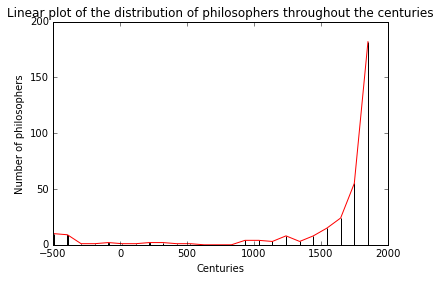

In [8]:
import numpy as np

birthdates = [birthdate for birthdate in philosophers_with_birthdates.values() if birthdate >= -500]

# Start at century 500 BC as requested
min_century = -500
max_century = max(birthdates)

# Compute the bins for our degree distribution
bins = (max_century - min_century) / 100

centuries_hist, centuries_bin = np.histogram(birthdates, bins=bins)

plt.plot(centuries_bin[:-1], centuries_hist, 'r')
plt.bar(centuries_bin[:-1], centuries_hist, color='b')
plt.xlabel('Centuries')
plt.ylabel('Number of philosophers')
plt.title('Linear plot of the distribution of philosophers throughout the centuries')
plt.show()

Based on the plot, we can see that the number of philosophers we have in our data is particularly low between 500 BC and 1500 AD and then litteraly bursts until our century from around 20 philosophers to slightly more than 180. 

We can say that we are living in an age where there a lot of philosophers, but as for the Golden Age, .. 

However, we must be careful that those are birth dates, and typically a philosopher born at the end of a century will not be counted into the century in which he actually was a proper philosopher. 

* ** Is the undirected version of the graph assortative with respect to age? Once again, provide an interpretation of your answer.**

In [9]:
phil_age_assortativity = nx.attribute_assortativity_coefficient(phi_network_birthdates_undirected,'birthdate')

print phil_age_assortativity

-0.00244172415775


* ** A reasonable hypothesis is that old philosophers are more famous. Create a scatter-plot of age versus in-degree. Do you see a correlation between the two? Justify your answer (for example by calculating the correlation coefficient.)** 

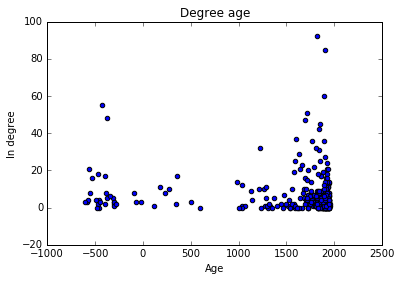

In [10]:
ages = philosophers_with_birthdates.values()
in_degrees = [phi_network_birthdates.in_degree(node) for node in phi_network_birthdates]

plt.scatter(ages, in_degrees)
plt.xlabel('Age')
plt.ylabel('In degree')
plt.title('Degree age')
plt.show()

## Part B: The branches of philosophy. Are they communities?

*Exercises*: We will use the concept of modularity to explore how community-like the six branches of philosophy are.

* ** Explain the concept of modularity in your own words. **

Modularity is .. 

** Now we will calculate the modularity of the branches reported by the Wikipedia editors. But we need to do a bit of work to make this happen. **
** Firstly, modularity does not work when the communities are overlapping. Thus, we need to do something about the philosophers that are part of multiple branches. We will handle it by creating a set of six new branches, where we take all of the philosophers that belong to more than one branch and assign them to the branch that they have the most connections to. The procedure is the following: **

*    ** Start with creating six new branches (e.g. represented as sets in Python) containing all of the philosopher that can be unambiguously assigned to a branch. **

In [11]:
import io
# More advanced regex that captures links with whitespaces and doesn't require any manual pre-processing of the file
re_wiki_link = r'\*.*?\[\[([^\[\]|]+)[^\[\]]*\]\]' 

def load_philosophers_from_file(file_name):
    f = io.open(file_name, 'r', encoding='utf-8')

    # Find all matches
    philosophers_matches = re.findall(re_wiki_link, f.read())
    return philosophers_matches

def create_philosophers_dict():
    philosophers_branches = {}
    
    aestheticians_matches = load_philosophers_from_file('philosophers_aestheticians.txt')
    epistemologists_matches = load_philosophers_from_file('philosophers_epistemologists.txt')
    ethicists_matches = load_philosophers_from_file('philosophers_ethicists.txt')
    logicians_matches = load_philosophers_from_file('philosophers_logicians.txt')
    metaphysicians_matches = load_philosophers_from_file('philosophers_metaphysicians.txt')
    sociopoliticians_matches = load_philosophers_from_file('philosophers_sociopolitical.txt')
    
    def if_philosopher_in_branch(philosopher, branch_name, branch_matches):
        if philosopher in branch_matches:
            if philosopher in philosophers_branches:
                philosophers_branches[philosopher].add(branch_name)
            else:
                philosophers_branches[philosopher] = {branch_name} 
    
    def check_if_philosopher_in_one_branch(philosopher):
        if_philosopher_in_branch(philosopher, 'aestheticians', aestheticians_matches)
        if_philosopher_in_branch(philosopher, 'epistemologists', epistemologists_matches)
        if_philosopher_in_branch(philosopher, 'ethicists', ethicists_matches)
        if_philosopher_in_branch(philosopher, 'logicians', logicians_matches)
        if_philosopher_in_branch(philosopher, 'metaphysicians', metaphysicians_matches)
        if_philosopher_in_branch(philosopher, 'sociopoliticians', sociopoliticians_matches)
    
    for philosopher in philosophers_unique:
        check_if_philosopher_in_one_branch(philosopher)
        
    return philosophers_branches

In [39]:
philosophers_branches = create_philosophers_dict()

branches_unambigous = {}
philosophers_ambigous = {}

for philosopher, branches in philosophers_branches.iteritems():
    if len(branches) == 1:
        current_branch = next(iter(branches))
        if current_branch in branches_unambigous:
            branches_unambigous[current_branch].add(philosopher)
        else:
            branches_unambigous[current_branch] = {current_branch}
    elif len(branches) > 1:
        philosophers_ambigous[philosopher] = {}

print branches_unambigous.keys()

set(['epistemologists', 'sociopoliticians', 'aestheticians', 'ethicists'])
['sociopoliticians', 'aestheticians', 'logicians', 'epistemologists', 'metaphysicians', 'ethicists']


* **Then, take the list of all nodes that are part of more than one branch. For each member i of this list, how many links i has to each of his/her branches. **

In [41]:
# TODO : How to handle the case where we have a link between two philosophers that are part of many branches ? 
philosophers_post = {}

for philosopher, branches in philosophers_ambigous.iteritems():
    links = undirected_phi_network.edges(philosopher) 
    for link in links:
        if link[1] in philosophers_ambigous:
            if philosopher in philosophers_post:
                philosophers_post[philosopher].append(link[1])
            else:
                philosophers_post[philosopher] = [link[1]}]
            continue
        for branch, philosophers in branches_unambigous.iteritems():
            if link[1] in philosophers:
                if branch in philosophers_ambigous[philosopher]:
                    philosophers_ambigous[philosopher][branch] += 1
                else:
                    philosophers_ambigous[philosopher][branch] = 0
                break
            else:
                continue
                
print philosophers_ambigous

{u'Christian Wolff (philosopher)': {'aestheticians': 0, 'sociopoliticians': 0, 'logicians': 0, 'ethicists': 0}, u'Martin Heidegger': {'sociopoliticians': 15, 'aestheticians': 3, 'logicians': 0, 'epistemologists': 1, 'metaphysicians': 7, 'ethicists': 7}, u'Thomas Hill Green': {'logicians': 0, 'aestheticians': 0, 'epistemologists': 0}, u'Jeremy Bentham': {'sociopoliticians': 4, 'logicians': 0, 'metaphysicians': 0, 'ethicists': 9}, u'Martha Nussbaum': {'sociopoliticians': 1, 'aestheticians': 0, 'ethicists': 3}, u'Joxe Azurmendi': {'sociopoliticians': 0, 'aestheticians': 0}, u'John Hospers': {}, u'Walter Terence Stace': {'sociopoliticians': 0, 'aestheticians': 0, 'metaphysicians': 0, 'ethicists': 0}, u'Jessica Wilson': {}, u'Baruch Spinoza': {'epistemologists': 1, 'sociopoliticians': 8, 'aestheticians': 6, 'metaphysicians': 5, 'ethicists': 5}, u'Francis Hutcheson (philosopher)': {'logicians': 0, 'sociopoliticians': 1, 'aestheticians': 2, 'metaphysicians': 0, 'ethicists': 6}, u'Niccol\xf2 M

In [43]:
for philosopher, branches in philosophers_ambigous.iteritems():
    max_branch = ""
    max_count = 0
    for branch, count in branches.iteritems():
        if count >= max_count:
            max_count = count
            max_branch = branch
    if max_count != 0:
        branches_unambigous[max_branch].add(philosopher)